# This file finds the ATE and runs a sensitivity analysis on cleaned data

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
import pathlib
import matplotlib.pyplot as plt
from austen_plots.AustenPlot import AustenPlot

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Data Loading and Initial Fit

Load the data

##Just change the file read in to replicate results for other data setups.

In [190]:
data = pd.read_csv('cleaned_liquor_data_0.4km-circles.csv', sep='\t').dropna().reset_index(drop=True)

In [169]:
data["Year"] = data.apply(lambda row: row['DATE ISSUED'].split('-')[0], axis=1).dropna()

In [170]:
# scale continuous covariates
cont_vars = ['PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED', 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'Birth Rate', 'General Fertility Rate',
       'Low Birth Weight', 'Prenatal Care Beginning in First Trimester',
        'Preterm Births', 'Teen Birth Rate', 'Breast cancer in females',
       'Cancer (All Sites)', 'Colorectal Cancer', 'Diabetes-related',
       'Infant Mortality Rate', 'Lung Cancer', 'Prostate Cancer in Males',
       'Stroke (Cerebrovascular Disease)', 'Childhood Blood Lead Level Screening',
        'Childhood Lead Poisoning', 'Tuberculosis',
       'Below Poverty Level', 'Crowded Housing', 'Dependency', "Year",
       'No High School Diploma', 'Per Capita Income', 'Unemployment', 'num old crimes']

data[cont_vars] = preprocessing.scale(data[cont_vars])

In [171]:
confounders = data[['PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED', 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'Unemployment', 'PER CAPITA INCOME ', 'Crowded Housing',
       'Below Poverty Level', 'Dependency',
       'No High School Diploma', 'HARDSHIP INDEX', 'Birth Rate', 'General Fertility Rate',
       'Low Birth Weight', 'Prenatal Care Beginning in First Trimester',
       'Preterm Births', 'Teen Birth Rate', 'Breast cancer in females',
       'Cancer (All Sites)', 'Colorectal Cancer', 'Diabetes-related',
       'Infant Mortality Rate', 'Lung Cancer', 'Prostate Cancer in Males',
       'Stroke (Cerebrovascular Disease)', "Year",
       'Childhood Blood Lead Level Screening', 'Childhood Lead Poisoning', 'Tuberculosis',
       'num old crimes']]
outcome = data['CHANGE IN CRIMES']
treatment = data['IS TREATED']

## Specify Nuisance Function Models

The next step is to specify models for the conditional expected outcome and propensity score

In [191]:
# specify a model for the conditional expected outcome

# make a function that returns a sklearn model for later use in k-folding
def make_Q_model():
    # return MLPRegressor(hidden_layer_sizes=(80,20), max_iter=500, learning_rate ='adaptive', random_state=RANDOM_SEED)
  return LinearRegression()
  # return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=200, max_depth=None)
  # return GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=200, max_depth=5)
Q_model = make_Q_model()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Q_model.fit(X_train, y_train)
y_pred = Q_model.predict(X_test)

test_mse=mean_squared_error(y_pred, y_test)
print(f"Test MSE of fit model {test_mse}") 
baseline_mse=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse}")

Test MSE of fit model 150120.07550602488
Test MSE of no-covariate model 173598.58415713152


In [192]:
# specify a model for the propensity score
def make_g_model():
  return LogisticRegression(max_iter=1000)
  # return RandomForestClassifier(n_estimators=100, max_depth=5)
  # return GradientBoostingClassifier(n_estimators=100, max_depth=3)

g_model = make_g_model()
# check that chosen model actually improves test error
X_train, X_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2, stratify=treatment)
g_model.fit(X_train, a_train)
a_pred = g_model.predict_proba(X_test)[:,1]

test_ce=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce}") 
baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce}")

Test CE of fit model 0.6647822681962453
Test CE of no-covariate model 0.6931471805599453


In [193]:
# # Compute feature importances
for index, value in enumerate(X_w_treatment):
   print(f"Input('{index}')<= {value}")
if type(g_model) == RandomForestClassifier or type(g_model) == GradientBoostingClassifier:
    propensity_importances = g_model.feature_importances_
    print("g model feature importances increasing: ", np.argsort(propensity_importances)[-10:])
if type(g_model) == LogisticRegression:
    print("g model feature importances increasing: ", np.argsort(g_model.coef_)[-10:])

if type(Q_model) == LinearRegression:
    print("Q model feature importances increasing: ", np.argsort(Q_model.coef_)[-10:])
if type (Q_model) == RandomForestRegressor or type (Q_model) == GradientBoostingRegressor:
    outcome_importances = Q_model.feature_importances_
    print("Q model feature importances increasing: ", np.argsort(outcome_importances)[-10:])

Input('0')<= PERCENT OF HOUSING CROWDED
Input('1')<= PERCENT HOUSEHOLDS BELOW POVERTY
Input('2')<= PERCENT AGED 16+ UNEMPLOYED
Input('3')<= PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA
Input('4')<= PERCENT AGED UNDER 18 OR OVER 64
Input('5')<= Unemployment
Input('6')<= PER CAPITA INCOME 
Input('7')<= Crowded Housing
Input('8')<= Below Poverty Level
Input('9')<= Dependency
Input('10')<= No High School Diploma
Input('11')<= HARDSHIP INDEX
Input('12')<= Birth Rate
Input('13')<= General Fertility Rate
Input('14')<= Low Birth Weight
Input('15')<= Prenatal Care Beginning in First Trimester
Input('16')<= Preterm Births
Input('17')<= Teen Birth Rate
Input('18')<= Breast cancer in females
Input('19')<= Cancer (All Sites)
Input('20')<= Colorectal Cancer
Input('21')<= Diabetes-related
Input('22')<= Infant Mortality Rate
Input('23')<= Lung Cancer
Input('24')<= Prostate Cancer in Males
Input('25')<= Stroke (Cerebrovascular Disease)
Input('26')<= Year
Input('27')<= Childhood Blood Lead Level Screeni

## Use cross fitting to get get predicted outcomes and propensity scores for each unit

In [194]:
# helper functions to implement the cross fitting

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
      X_train = X_w_treatment.loc[train_index]
      y_train = y.loc[train_index]
      q = make_model()
      q.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = q.predict(X0.loc[test_index])
        predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

Text(0, 0.5, 'Count')

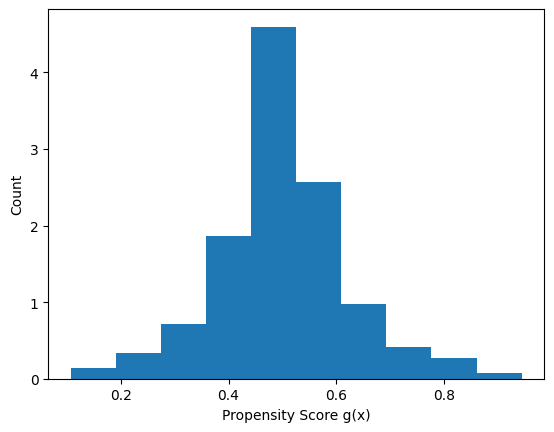

In [195]:
# get propensity scores
g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=5)
plt.hist(g, density=True)
plt.xlabel('Propensity Score g(x)')
plt.ylabel('Count') 

In [196]:
Q0,Q1=outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, n_splits=10, output_type="continuous")

In [197]:
data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates.head()

,g,Q0,Q1,A,Y
0,0.612810,-126.777160,-17.248633,1,-821.0
1,0.505585,-98.465398,9.256993,1,231.0
2,0.592189,-189.226253,-88.528486,1,9.0
3,0.600214,50.707176,156.566464,1,-378.0
4,0.589955,-240.354903,-144.633823,1,133.0


## Combine predicted values and data into estimate of ATE

In [198]:
def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATE
  """

  tau_hat = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g)).mean()
  
  scores = Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g) - tau_hat
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


In [199]:
tau_hat, std_hat = ate_aiptw(**data_and_nuisance_estimates)
print(f"The estimate is {tau_hat} pm {1.96*std_hat}")

The estimate is 133.45590395286894 pm 53.05113235325124


#Sensitivity Analysis

We use the 0.95 CI level as the target bias

In [200]:
# the first step is to choose a level of bias that would undermine the qualitative conclusion of the study
# we'll go with the nominal effect
target_bias = 1.96*std_hat # lower bound of 0.95 CI
# target_bias = 10.0 # note: bias is specified as an absolute number

## Compute influence strength of covariates
Our task is to assess whether it's plausible that an unobserved confounder could be strong enough to induce a bias of 2 or more. To make that easier, we'd like to know how strong the observed confounders are. Austen plots computes these reference strengths by seeing how much model performance degrades when the covariates are removed. Accordingly, we refit the models with each (group of) reference covariate removed.  

In [201]:
# First, lets define the groups of covariates we'll measure the strength of.
# Note: it's important to group the covariates into meaningful groups, because strength is measured conditional on all remaining covariates
# E.g., if we remove only "black" (and not "hispanic, white") then we will measure no effect, because we can infer the removed variable from the remaining ones

covariate_groups = {
    'socioeconomic': ['PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED', 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'Unemployment', 'PER CAPITA INCOME ', 'Crowded Housing',
       'Below Poverty Level', 'Dependency',
       'No High School Diploma', 'HARDSHIP INDEX'],
    'population health': ['Birth Rate', 'General Fertility Rate',
       'Low Birth Weight', 'Prenatal Care Beginning in First Trimester',
       'Preterm Births', 'Teen Birth Rate', 'Breast cancer in females',
       'Cancer (All Sites)', 'Colorectal Cancer', 'Diabetes-related',
       'Infant Mortality Rate', 'Lung Cancer', 'Prostate Cancer in Males',
       'Stroke (Cerebrovascular Disease)',
       'Childhood Blood Lead Level Screening', 'Childhood Lead Poisoning', 'Tuberculosis'],
    'previous crime rate': ['num old crimes'],
    'year': ['Year']}

In [202]:
# For each covariate group, refit the models without using that group
nuisance_estimates = {}
for group, covs in covariate_groups.items():
  remaining_confounders = confounders.drop(columns=covs)

  g = treatment_k_fold_fit_and_predict(make_g_model, X=remaining_confounders, A=treatment, n_splits=5)
  Q0, Q1 = outcome_k_fold_fit_and_predict(make_Q_model, X=remaining_confounders, y=outcome, A=treatment, n_splits=5, output_type="continuous")

  data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})
  nuisance_estimates[group] = data_and_nuisance_estimates


## Save computed estimates as CSVs
The Austen plot code expects the nuisance function estimates to be provided as csvs with columns 'g', 'Q', 't', 'y'

In [203]:
data_and_nuisance_path = 'data_and_nuisance_estimates.csv'
covariate_dir_path = 'covariates/'

In [204]:
def _convert_to_austen_format(nuisance_estimate_df: pd.DataFrame):
  austen_df = pd.DataFrame()
  austen_df['y']=nuisance_estimate_df['Y']
  austen_df['t']=nuisance_estimate_df['A']
  austen_df['g']=nuisance_estimate_df['g']
  A = nuisance_estimate_df['A']
  austen_df['Q']=A*nuisance_estimate_df['Q1'] + (1-A)*nuisance_estimate_df['Q0'] # use Q1 when A=1, and Q0 when A=0

  return austen_df

In [205]:
austen_data_and_nuisance = _convert_to_austen_format(data_and_nuisance_estimates)
austen_data_and_nuisance.to_csv(data_and_nuisance_path, index=False)

pathlib.Path(covariate_dir_path).mkdir(exist_ok=True)
for group, nuisance_estimate in nuisance_estimates.items():
  austen_nuisance_estimate = _convert_to_austen_format(nuisance_estimate)
  austen_nuisance_estimate.to_csv(os.path.join(covariate_dir_path,group+".csv"), index=False)

## Make plots

In [206]:
ap = AustenPlot(data_and_nuisance_path, covariate_dir_path)

In [207]:
p, plot_coords, variable_coords = ap.fit(bias=target_bias) # we set target_bias to 0.95 CI

Fitting main dataset


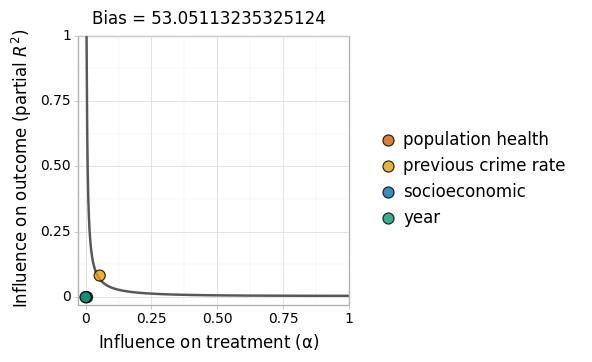

<ggplot: (181719818463)>

In [208]:
p